## XBRL US API - FERC 714 Part III - Schedule 2. Planning Area Hourly Demand

### Authenticate for access token 
Click in the gray code cell below, then click the Run button above to execute the cell. Type your XBRL US Web account email, account password, Client ID, and secret as noted, pressing the Enter key on the keyboard after each entry.

XBRL US limits records returned for a query to improve efficiency; this script loops to collect all data from the Public Filings Database for a query. **Non-members might not be able to return all data for a query** - join XBRL US for comprehensive access - https://xbrl.us/join.

In [ ]:
print('Enter your XBRL US Web account email: ')
import os, re, sys, json
import requests
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import getpass
from datetime import datetime
import urllib
from urllib.parse import urlencode
# this pip installs package to support plotting data in this notebook when it's opened from the Web using Chrome or Firefox
%pip install matplotlib -q
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
email = input()
password = getpass.getpass(prompt='Password: ')
clientid = getpass.getpass(prompt='Client ID: ')
secret = getpass.getpass(prompt='Secret: ')

body_auth = {'username' : ''.join(email), 
            'client_id': ''.join(clientid), 
            'client_secret' : ''.join(secret), 
            'password' : ''.join(password), 
            'grant_type' : 'password', 
            'platform' : 'ipynb' }

payload = urlencode(body_auth)
url = 'https://api.xbrl.us/oauth2/token'
headers = {"Content-Type": "application/x-www-form-urlencoded"}

res = requests.request("POST", url, data=payload, headers=headers)
auth_json = res.json()

if 'error' in auth_json:
    print ("\n\nThere was a problem generating an access token with these credentials. Run the first cell again to enter credentials.")
else:
    print ("\n\nYour access token expires in 60 minutes. After it expires, run the cell immediately below this one to generate a new token and continue to use the query cell. \n\nFor now, skip ahead to the section 'Make a Query'.")

access_token = auth_json['access_token']
refresh_token = auth_json['refresh_token']
newaccess = ''
newrefresh = ''
#print('access token: ' + access_token + ' refresh token: ' + refresh_token)

#### Refresh token 
The cell below is only needed to refresh an expired access token after 60 minutes. When the access token no longer returns results, run the cell below to refresh the access token or re-enter credentials by running the cell above. Until the refresh token process is needed, **skip ahead to _Make a Query_**. 


In [ ]:
token = token if newrefresh != '' else refresh_token 

refresh_auth = {'client_id': ''.join(clientid), 
            'client_secret' : ''.join(secret), 
            'grant_type' : 'refresh_token', 
            'platform' : 'ipynb', 
            'refresh_token' : ''.join(token) }
refreshres = requests.post(url, data=refresh_auth)
refresh_json = refreshres.json()
access_token = refresh_json['access_token']
refresh_token = refresh_json['refresh_token']#print('access token: ' + access_token + 'refresh token: ' + refresh_token)
print('Your access token is refreshed for 60 minutes. If it expires again, run this cell to generate a new token and continue to use the query cells below.')
print(access_token)

### Make a query 
After the access token confirmation appears above, you can modify the query below and use the **_Cell >> Run_** menu option with the cell **immediately below this text** to run the query for updated results. 

The sample results are for one concept reported hourly for two fiscal years of data by an entity filing data on Form 714 for 2022.  **To get more entities, paste the query for _a list of Form 714 filer entity codes_ (below) into a browser and login to XBRL US**, then copy value(s) as a comma-separated list into the corresponding line below.
  
Refer to XBRL API documentation at https://xbrlus.github.io/xbrl-api/#/Facts/getFactDetails for other endpoints and parameters to filter and return. 

In [ ]:
# Define the parameters for the filter and fields to be returned,
# run the loop to return results
offset_value = 0
res_df = []

# Define the parameters of the query

document_type = [
    '714'
    ]

report_section = [
    'PlanningAreaHourlyDemandMegawatts'
    ]

# query for a list of Form 714 filer entity codes:
# https://api.xbrl.us/api/v1/report/search?report.document-type=714&fields=report.entity-name.sort(ASC),entity.code&unique

entity_codes = [
    'C000038','C000029',
    ]

fiscal_years = [
    '2021','2022'
    ]

# Define data fields to return (multi-sort based on order)

fields = [ # this is the list of the characteristics of the data being returned by the query
		'entity.name.sort(ASC)',
        'entity.code',
        'period.instant.sort(ASC)',
		'fact.value',
		'period.fiscal-year',
		'concept-local-name',
        'report.html-url'
        ]

params = { # this is the list of what's being queried against the search endpoint
         'report.document-type': ','.join(document_type),
         'concept.local-name': ','.join(report_section),
         'entity.code': ','.join(entity_codes),
         'period.fiscal-year': ','.join(fiscal_years),
         'fact.ultimus': 'TRUE',
         'fields': ','.join(fields)
         }

# Execute the query with loop for all results
endpoint = 'fact'
search_endpoint = 'https://api.xbrl.us/api/v1/' + endpoint + '/search'
orig_fields = params['fields']

count = 0
query_start = datetime.now()
printed = False
while True:
    if not printed:
        printed = True
    res = requests.get(search_endpoint, params=params, headers={'Authorization' : 'Bearer {}'.format(access_token)})
    res_json = res.json()
    if 'error' in res_json:
        print('There was an error: {}'.format(res_json['error_description']))
        break

    print("up to", str(offset_value + res_json['paging']['limit']), "records are found so far ...")

    res_df += res_json['data']

    if res_json['paging']['count'] < res_json['paging']['limit']:
        print(" - this set contained fewer than the", res_json['paging']['limit'], "possible, only", str(res_json['paging']['count']), "records.")
        break
    else:
        offset_value += res_json['paging']['limit']
        if 100 == res_json['paging']['limit']:
                params['fields'] = orig_fields + ',' + endpoint + '.offset({})'.format(offset_value)
                if offset_value == 10 * res_json['paging']['limit']:
                        break
        elif 500 == res_json['paging']['limit']:
                params['fields'] = orig_fields + ',' + endpoint + '.offset({})'.format(offset_value)
                if offset_value == 4 * res_json['paging']['limit']:
                        break
        params['fields'] = orig_fields + ',' + endpoint + '.offset({})'.format(offset_value)

if not 'error' in res_json:
    current_datetime = datetime.now().replace(microsecond=0)
    time_taken = current_datetime - query_start
    index = pd.DataFrame(res_df).index
    total_rows = len(index)
    your_limit = res_json['paging']['limit']
    limit_message = "If the results below match the limit noted above, you might not be seeing all rows, and should consider upgrading (https://xbrl.us/access-token).\n"

    if your_limit == 100:
        print("\nThis non-Member account has a limit of " , 10 * your_limit, " rows per query from our Public Filings Database. " + limit_message)
    elif your_limit == 500:
        print("\nThis Basic Individual Member account has a limit of ", 4 * your_limit, " rows per query from our Public Filings Database. " + limit_message)

    print("\nAt " + current_datetime.strftime("%c") +  ", the query finished with  ", str(total_rows), "  rows returned in " + str(time_taken) + " for \n" +  urllib.parse.unquote(res.url))

    df = pd.DataFrame(res_df)

    # the format truncates the HTML display of numerical values to two decimals; .csv data is unaffected
    pd.options.display.float_format = '{:,.2f}'.format
    display(HTML(df.to_html(max_rows=6)))

    # set period.instant as datetimeindex for resampling
    df['period.instant'] = pd.to_datetime(df['period.instant'], format='%Y-%m-%d %H:%M:%S')
    df = df.set_index('period.instant')
    df.index = pd.to_datetime(df.index)

up to 5000 records are found so far ...
up to 10000 records are found so far ...
up to 15000 records are found so far ...
up to 20000 records are found so far ...
up to 25000 records are found so far ...
up to 30000 records are found so far ...
up to 35000 records are found so far ...
 - this set contained fewer than the 5000 possible, only 4562 records.

At Fri Dec  1 22:15:23 2023, the query finished with   34562   rows returned in 0:00:09.100299 for 
https://api.xbrl.us/api/v1/fact/search?report.document-type=714&concept.local-name=PlanningAreaHourlyDemandMegawatts&entity.code=C000038,C000029&period.fiscal-year=2021,2022&fact.ultimus=TRUE&fields=entity.name.sort(ASC),entity.code,period.instant.sort(ASC),fact.value,period.fiscal-year,concept-local-name,report.html-url,fact.offset(30000)


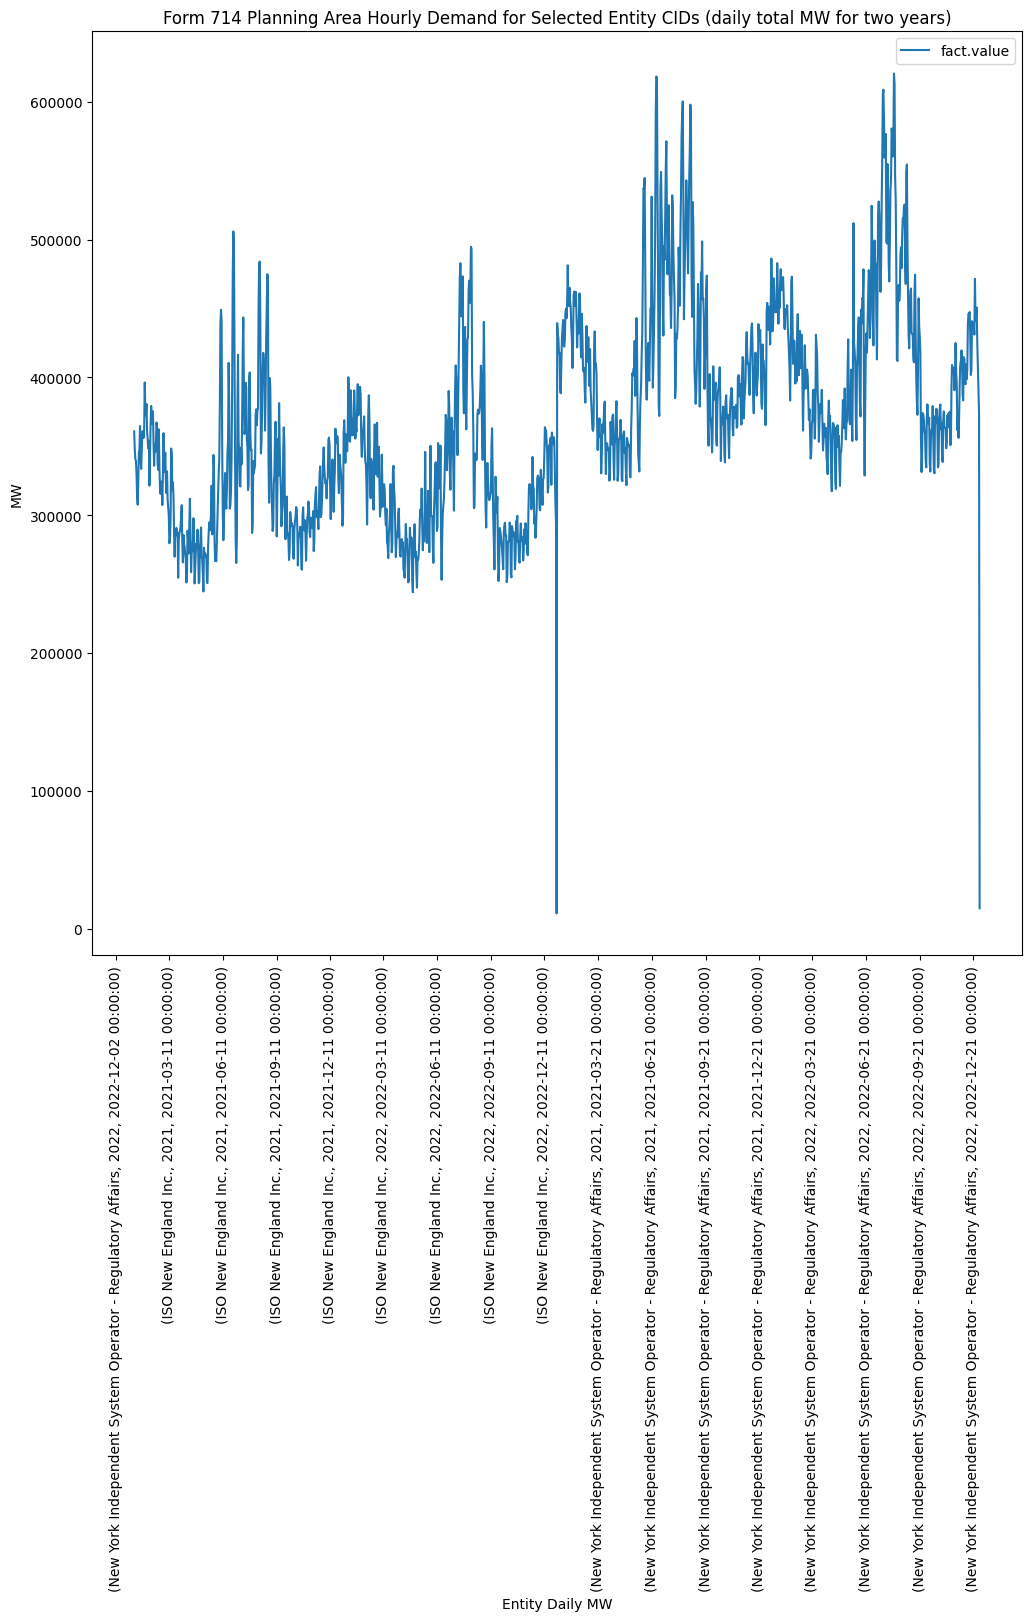

In [ ]:
# resample hourly data to daily sum and plot by entity
grouped = df.groupby(['entity.name','period.fiscal-year']).resample('d').sum('fact.value')

#print(grouped.to_string())

fig, ax = plt.subplots(figsize=(12,12))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
grouped.plot(kind='line',  y = "fact.value", ax=ax, rot=90, xlabel = "Entity Daily MW", ylabel="MW", title="Form 714 Planning Area Hourly Demand for Selected Entity CIDs (daily total MW for two years)")
plt.show()

In [ ]:
# If you run this program locally, you can save the output to a file on your computer (modify D:\results.csv to your system)
df.to_csv(r"D:\results.csv",sep=",")